In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [2]:
import argparse
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from torch.nn import functional as F

In [3]:
from lds import LDS

In [4]:
layer_i = 2
state_dim = 1000
batch_size = 2
epochs = 4000
seq_len = 8192
kx = 5
lr = 0.0001

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize LDS model
lds = LDS(state_dim, 896, 896, kx).to(device)
optimizer = torch.optim.Adam(lds.parameters(), lr=lr)
# Training
lds_loss_values = []

best_loss = float('inf')

In [5]:
# Load the filter from filter_2_impulse.pth
try:
    stu_impulse = torch.load("filter_2_impulse.pth", map_location=device)
    print(f"Successfully loaded filter with shape: {stu_impulse.shape}")
except Exception as e:
    print(f"Error loading filter: {e}")
    stu_impulse = None


/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_4256/3864558947.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stu_impulse = torch.load("filter_2_impulse.pth

Successfully loaded filter with shape: torch.Size([1024, 896, 896])


In [7]:
#  NOT USED
try:
    phi = torch.load("phi.pth", map_location=device)
    print(f"Successfully loaded phi with shape: {phi.shape}")
except Exception as e:
    print(f"Error loading phi: {e}")
    phi = None


Successfully loaded phi with shape: torch.Size([8192, 24])


/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_4256/485362044.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  phi = torch.load("phi.pth", map_location=device

In [8]:
seq_len = 1024
phi = phi[:seq_len, :]

In [9]:
lds.M.shape

torch.Size([896, 896, 5])

In [ ]:
import torch
import torch.nn.functional as F

for epoch in range(epochs):
    optimizer.zero_grad()
    
    total_loss = 0.0
    
    # Get model parameters
    A = lds.A
    B = lds.B
    C = lds.C
    M = lds.M
    
    # Compute loss by summing (C.T @ A^i @ B.T + M[:,:,i] - stu_impulse[i])**2 directly
    running_loss = 0.0
    
    for i in range(seq_len):
        # Compute C @ A^i @ B directly for the impulse response at time i
        # This is equivalent to computing the impulse response at time i
        x = B.T
        x = (A**i).reshape(-1,1) * x
        y_pred = C.T @ x
        
        # Add M[:,:,i] for the first kx steps
        if i < kx:
            y_pred = y_pred + M[:,:,i]
        
        # Compute squared error with stu_impulse[i]
        squared_error = torch.sum((y_pred - stu_impulse[i])**2)
        running_loss += squared_error
    
    # Compute mean squared error
    total_loss = running_loss / seq_len
    total_loss.backward()
    
    torch.nn.utils.clip_grad_norm_(lds.parameters(), max_norm=1)
    lds_loss_values.append(total_loss.item())
    optimizer.step()

    with torch.no_grad():
        lds.A.data.clamp_(max=1, min=-1)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item()}")

Epoch 0, Loss: 0.693693995475769
Epoch 10, Loss: 0.6490765810012817
Epoch 20, Loss: 0.6072869300842285
Epoch 30, Loss: 0.565933883190155
Epoch 40, Loss: 0.5246268510818481
Epoch 50, Loss: 0.4839085042476654
Epoch 60, Loss: 0.44451671838760376
Epoch 70, Loss: 0.40706342458724976
Epoch 80, Loss: 0.37197598814964294
Epoch 90, Loss: 0.3395042419433594


In [11]:
torch.save(lds.state_dict(), "lds_10k_5_impulse.pth")

LDS impulse shape: torch.Size([1024, 896, 896])
STU impulse shape: torch.Size([1024, 896, 896])
Mean Squared Error between LDS and STU impulse: 5.299548320181202e-07


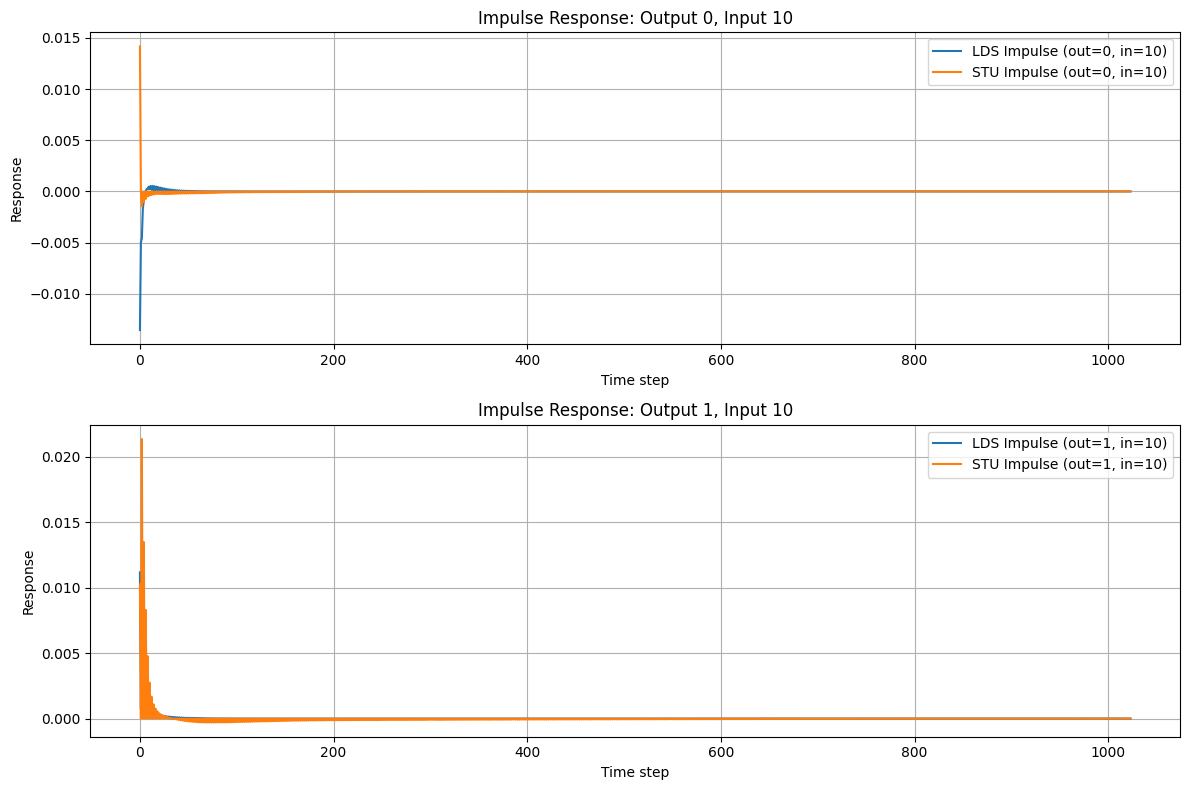

In [24]:
# Compute the impulse response of the trained LDS model
with torch.no_grad():
    lds_impulse = lds.impulse(seq_len=stu_impulse.shape[0])

# Print shapes for verification
print(f"LDS impulse shape: {lds_impulse.shape}")
print(f"STU impulse shape: {stu_impulse.shape}")

# Compute the mean squared error between the two impulse responses
mse = torch.mean((lds_impulse - stu_impulse) ** 2)
print(f"Mean Squared Error between LDS and STU impulse: {mse.item()}")

# Visualize a few impulse responses for comparison
import matplotlib.pyplot as plt

# Select a few input-output pairs to visualize
input_idx = 10  # First input dimension
output_indices = [0, 1]  # First two output dimensions

plt.figure(figsize=(12, 8))
for i, output_idx in enumerate(output_indices):
    plt.subplot(len(output_indices), 1, i+1)
    
    # Plot LDS impulse response
    plt.plot(lds_impulse[:, output_idx, input_idx].cpu().numpy(), 
             label=f'LDS Impulse (out={output_idx}, in={input_idx})')
    
    # Plot student impulse response
    plt.plot(stu_impulse[:, output_idx, input_idx].cpu().numpy(), 
             label=f'STU Impulse (out={output_idx}, in={input_idx})')
    
    plt.title(f'Impulse Response: Output {output_idx}, Input {input_idx}')
    plt.xlabel('Time step')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


MSE between LDS and STU responses to Gaussian input: 0.044980064034461975


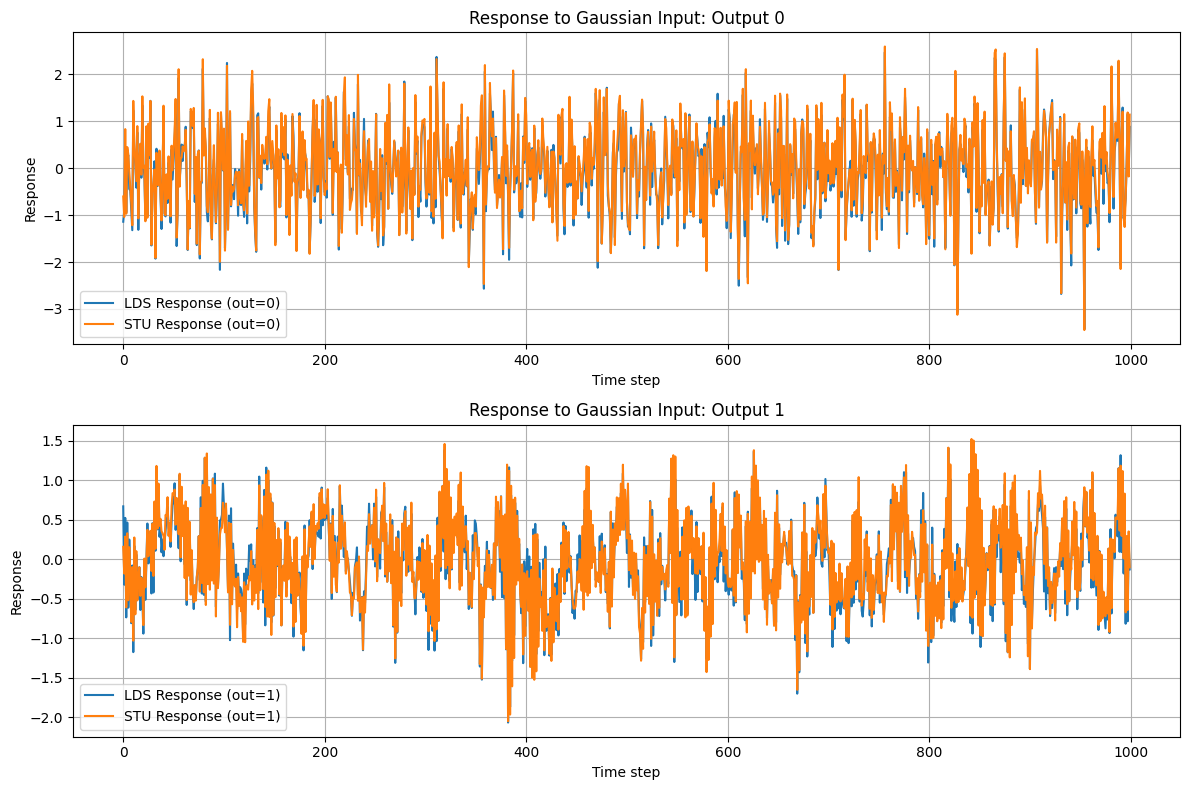

In [25]:
# Test how the models respond to Gaussian input
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generate Gaussian input sequence
seq_len = 1000
input_dim = stu_impulse.shape[2]  # Get input dimension from the impulse shape
batch_size = 1

# Create random Gaussian input
np.random.seed(42)  # For reproducibility
gaussian_input = torch.tensor(np.random.normal(0, 1, (batch_size, seq_len, input_dim)), 
                             dtype=torch.float32).to(device)

# Run both models on the same input
with torch.no_grad():
    # Get LDS response to Gaussian input
    lds_response = lds(gaussian_input)
    
    # For STU, we need to use the impulse response to compute the output
    # This is essentially a convolution of the input with the impulse response
    stu_response = torch.zeros((batch_size, seq_len, stu_impulse.shape[1]), 
                              dtype=torch.float32).to(device)
    
    # Convolve input with impulse response
    for b in range(batch_size):
        for t in range(seq_len):
            for tau in range(min(t+1, stu_impulse.shape[0])):
                stu_response[b, t] += torch.matmul(
                    stu_impulse[tau], gaussian_input[b, t-tau]
                )

# Compute MSE between responses
response_mse = torch.mean((lds_response - stu_response) ** 2)
print(f"MSE between LDS and STU responses to Gaussian input: {response_mse.item()}")

# Visualize a few output dimensions
output_indices = [0, 1]  # First two output dimensions

plt.figure(figsize=(12, 8))
for i, output_idx in enumerate(output_indices):
    plt.subplot(len(output_indices), 1, i+1)
    
    # Plot LDS response
    plt.plot(lds_response[0, :, output_idx].cpu().numpy(), 
             label=f'LDS Response (out={output_idx})')
    
    # Plot STU response
    plt.plot(stu_response[0, :, output_idx].cpu().numpy(), 
             label=f'STU Response (out={output_idx})')
    
    plt.title(f'Response to Gaussian Input: Output {output_idx}')
    plt.xlabel('Time step')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

